In [ ]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import pymrmr

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from kneed import KneeLocator

# Retrieve Data from Google Drive

In [ ]:
df = pd.read_csv('../data/online_shoppers_intention.csv')

In [ ]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
df.dtypes.value_counts()

int64      7
float64    7
bool       2
object     2
dtype: int64

In [ ]:
X = df.drop(['Revenue'], axis = 1)
y = df['Revenue']

In [ ]:
X_num = X.iloc[:,:10]
X_cat = X.iloc[:,10:]

In [ ]:
print(X_num.head())
print(X_cat.head())

   Administrative  Administrative_Duration  ...  PageValues  SpecialDay
0               0                      0.0  ...         0.0         0.0
1               0                      0.0  ...         0.0         0.0
2               0                      0.0  ...         0.0         0.0
3               0                      0.0  ...         0.0         0.0
4               0                      0.0  ...         0.0         0.0

[5 rows x 10 columns]
  Month  OperatingSystems  Browser  ...  TrafficType        VisitorType Weekend
0   Feb                 1        1  ...            1  Returning_Visitor   False
1   Feb                 2        2  ...            2  Returning_Visitor   False
2   Feb                 4        1  ...            3  Returning_Visitor   False
3   Feb                 3        2  ...            4  Returning_Visitor   False
4   Feb                 3        3  ...            4  Returning_Visitor    True

[5 rows x 7 columns]


In [ ]:
X_cat.columns.values

array(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'], dtype=object)

In [ ]:
one = OneHotEncoder(sparse = False)
inter = one.fit_transform(X_cat)
cat_col = one.get_feature_names(X_cat.columns.values)
X_cat_1 = pd.DataFrame(inter, columns = cat_col)

#frame.to_csv("cat shopper.csv")

num_col = X_num.columns.values
ss = StandardScaler(with_mean = False)
X_num_s = pd.DataFrame(ss.fit_transform(X_num))
X_num_s.columns = num_col

In [ ]:
print(X_cat_1.head())
print(X_num_s.head())

   Month_Aug  Month_Dec  ...  Weekend_False  Weekend_True
0        0.0        0.0  ...            1.0           0.0
1        0.0        0.0  ...            1.0           0.0
2        0.0        0.0  ...            1.0           0.0
3        0.0        0.0  ...            1.0           0.0
4        0.0        0.0  ...            0.0           1.0

[5 rows x 65 columns]
   Administrative  Administrative_Duration  ...  PageValues  SpecialDay
0             0.0                      0.0  ...         0.0         0.0
1             0.0                      0.0  ...         0.0         0.0
2             0.0                      0.0  ...         0.0         0.0
3             0.0                      0.0  ...         0.0         0.0
4             0.0                      0.0  ...         0.0         0.0

[5 rows x 10 columns]


# Automate with a Full Pipeline

In [ ]:
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(with_mean=False), list(X_num)),
        ("cat", OneHotEncoder(sparse=False), list(X_cat)),
    ])

arr_prepared = full_pipeline.fit_transform(X)

In [ ]:
col_names = np.concatenate((num_col, cat_col))
X_prepared = pd.DataFrame(arr_prepared, columns = col_names)
df_prepared = pd.concat([X_prepared, y], axis = 1)

In [ ]:
df_prepared.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True,Revenue
0,0.0,0.0,0.0,0.0,0.022485,0.000000,4.124872,4.115686,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
1,0.0,0.0,0.0,0.0,0.044970,0.033445,0.000000,2.057843,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
2,0.0,0.0,0.0,0.0,0.022485,0.000000,4.124872,4.115686,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
3,0.0,0.0,0.0,0.0,0.044970,0.001394,1.031218,2.880980,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
4,0.0,0.0,0.0,0.0,0.224852,0.327917,0.412487,1.028922,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,False


In [ ]:
train_set, test_set = train_test_split(df_prepared, test_size = 0.3, random_state = 42, stratify = y)

In [ ]:
train_set

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True,Revenue
7460,1.204221,0.256828,0.0,0.0,0.314793,0.177154,0.000000,0.216615,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,False
4687,0.301055,0.227695,0.0,0.0,0.427219,0.262212,0.000000,0.216615,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
790,0.000000,0.000000,0.0,0.0,0.292308,0.127596,0.000000,0.633182,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
9057,1.806332,0.354977,0.0,0.0,1.034319,0.574064,0.146089,0.340159,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
225,0.000000,0.000000,0.0,0.0,0.044970,0.009929,0.000000,2.057843,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0.301055,0.079198,0.0,0.0,0.134911,0.081522,0.000000,0.823137,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,False
390,1.806332,0.404476,0.0,0.0,1.056804,0.800693,0.204781,0.407399,1.468620,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,True
1200,1.204221,0.094283,0.0,0.0,1.528994,1.355431,0.060660,0.264292,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
y_imbal = train_set["Revenue"]
X_imbal = train_set.drop("Revenue", axis = 1)

X_os, y_os = resample(X_imbal[y_imbal == 1], y_imbal[y_imbal == 1], replace = True,
n_samples = X_imbal[y_imbal == 0].shape[0], random_state = 42)

X_bal = pd.DataFrame(np.vstack((X_imbal[y_imbal == 0], X_os)))
y_bal = pd.DataFrame(np.hstack((y_imbal[y_imbal == 0], y_os)))
train_bal = pd.concat([X_bal, y_bal], axis = 1)
train_bal.columns = list(df_prepared)

In [ ]:
train_set.to_csv('train_origin.csv')
train_bal.to_csv('train_bal.csv')
test_set.to_csv('test.csv')

# Feature Selection

In [ ]:
data = df.copy()

In [ ]:
cat_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']

for col in cat_cols:
    data[col] = data[col].astype('category').cat.codes

In [ ]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                         int8
OperatingSystems              int8
Browser                       int8
Region                        int8
TrafficType                   int8
VisitorType                   int8
Weekend                       bool
Revenue                       bool
dtype: object

In [ ]:
corr = data.corr()['Revenue'][:-1]
corr_ranked = abs(corr).sort_values(ascending=False).index.values

In [ ]:
print(corr_ranked)

['PageValues' 'ExitRates' 'ProductRelated' 'ProductRelated_Duration'
 'BounceRates' 'Administrative' 'VisitorType' 'Informational'
 'Administrative_Duration' 'SpecialDay' 'Month' 'Informational_Duration'
 'Weekend' 'Browser' 'OperatingSystems' 'Region' 'TrafficType']


In [ ]:
from sklearn.feature_selection import mutual_info_classif

mutual_info_val = mutual_info_classif(data.iloc[:,:-1], data['Revenue'])
mutual_info = pd.Series(mutual_info_val, index = list(data.iloc[:,:-1]))
mutual_info_ranked = abs(mutual_info).sort_values(ascending=False).index.values

In [ ]:
print(mutual_info_ranked)

['PageValues' 'ExitRates' 'ProductRelated_Duration' 'BounceRates'
 'ProductRelated' 'TrafficType' 'Administrative' 'Administrative_Duration'
 'Month' 'Informational' 'VisitorType' 'SpecialDay'
 'Informational_Duration' 'OperatingSystems' 'Weekend' 'Browser' 'Region']


In [ ]:
data_mrmr = pd.concat([data.iloc[:,-1], data.iloc[:,:-1]], axis = 1)

In [ ]:
mRMR_MIQ = pymrmr.mRMR(data_mrmr, 'MIQ', 17)
mRMR_MID = pymrmr.mRMR(data_mrmr, 'MID', 17)

In [ ]:
feature_rank = pd.DataFrame(data={'corr': pd.Series(corr_ranked), 'mutual_info': pd.Series(mutual_info_ranked), 'mRMR': pd.Series(mRMR_MID)})

In [ ]:
feature_rank

,corr,mutual_info,mRMR
0,PageValues,PageValues,ProductRelated_Duration
1,ExitRates,ExitRates,ExitRates
2,ProductRelated,ProductRelated_Duration,BounceRates
3,ProductRelated_Duration,BounceRates,SpecialDay
4,BounceRates,ProductRelated,VisitorType
5,Administrative,TrafficType,Weekend
6,VisitorType,Administrative,PageValues
7,Informational,Administrative_Duration,OperatingSystems
8,Administrative_Duration,Month,Informational
9,SpecialDay,Informational,Month


In [ ]:
feature_score = {}

for col in list(data)[:-1]:
  if col not in feature_score:
    feature_score[col] = 0
  for i in range(0,3):
    rank_col = feature_rank.iloc[:,i]
    feature_score[col] += rank_col[rank_col == col].index[0]

In [ ]:
score_rank = sorted(feature_score.items(), key=lambda x: x[1])

In [ ]:
score_rank

[('ExitRates', 3),
 ('ProductRelated_Duration', 5),
 ('PageValues', 6),
 ('BounceRates', 9),
 ('VisitorType', 20),
 ('ProductRelated', 21),
 ('Administrative', 23),
 ('SpecialDay', 23),
 ('Informational', 24),
 ('Month', 27),
 ('Administrative_Duration', 31),
 ('Weekend', 31),
 ('OperatingSystems', 34),
 ('TrafficType', 34),
 ('Informational_Duration', 37),
 ('Browser', 39),
 ('Region', 41)]

In [ ]:
 feature_rank['Score'] = pd.Series([x[0] for x in score_rank])

In [ ]:
feature_rank

,corr,mutual_info,mRMR,Score
0,PageValues,PageValues,ProductRelated_Duration,ExitRates
1,ExitRates,ExitRates,ExitRates,ProductRelated_Duration
2,ProductRelated,ProductRelated_Duration,BounceRates,PageValues
3,ProductRelated_Duration,BounceRates,SpecialDay,BounceRates
4,BounceRates,ProductRelated,VisitorType,VisitorType
5,Administrative,TrafficType,Weekend,ProductRelated
6,VisitorType,Administrative,PageValues,Administrative
7,Informational,Administrative_Duration,OperatingSystems,SpecialDay
8,Administrative_Duration,Month,Informational,Informational
9,SpecialDay,Informational,Month,Month


In [ ]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12330 non-null  int64   
 1   Administrative_Duration  12330 non-null  float64 
 2   Informational            12330 non-null  int64   
 3   Informational_Duration   12330 non-null  float64 
 4   ProductRelated           12330 non-null  int64   
 5   ProductRelated_Duration  12330 non-null  float64 
 6   BounceRates              12330 non-null  float64 
 7   ExitRates                12330 non-null  float64 
 8   PageValues               12330 non-null  float64 
 9   SpecialDay               12330 non-null  float64 
 10  Month                    12330 non-null  category
 11  OperatingSystems         12330 non-null  int64   
 12  Browser                  12330 non-null  int64   
 13  Region                   12330 non-null  int64   
 14  Traffi

In [ ]:
data.corr()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,-0.006347,-0.025035,-0.005487,-0.033561,0.026417,0.138917
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,-0.007343,-0.015392,-0.005561,-0.014376,0.014990,0.093587
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,-0.009527,-0.038235,-0.029169,-0.034491,0.035785,0.095200
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,-0.009579,-0.019285,-0.027144,-0.024675,0.024078,0.070345
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.004290,-0.013146,-0.038122,-0.043064,0.016092,0.158538
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.002976,-0.007380,-0.033091,-0.036377,0.007311,0.152373
BounceRates,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.119386,0.072702,0.023823,-0.015772,-0.006485,0.078286,-0.046514,-0.150673
ExitRates,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.174498,0.102242,0.014567,-0.004442,-0.008907,0.078616,-0.062587,-0.207071
PageValues,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,-0.119386,-0.174498,1.000000,-0.063541,0.018508,0.045592,0.011315,0.012532,0.012002,0.492569
SpecialDay,-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.063541,1.000000,0.012652,0.003499,-0.016098,0.052301,-0.016767,-0.082305


In [ ]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x):
        if x <= -0.7 or x >= 0.7:
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

In [ ]:
def variance_explained(num_of_pcs,data):
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    return f.get_factor_variance()[2][num_of_pcs-1]

In [ ]:
data.replace("Returning_Visitor", 1)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,1,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,1,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,1,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,1,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,1,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,1,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,1,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,1,False,False


In [ ]:
data["VisitorType"] = data["VisitorType"].replace("Returning_Visitor", 1)
data["VisitorType"] = data["VisitorType"].replace("New_Visitor", 0)
data["Month"] = data["Month"].replace("Jan", 1)
data["Month"] = data["Month"].replace("Feb", 2)
data["Month"] = data["Month"].replace("Mar", 3)
data["Month"] = data["Month"].replace("Apr", 4)
data["Month"] = data["Month"].replace("May", 5)
data["Month"] = data["Month"].replace("June", 6)
data["Month"] = data["Month"].replace("Jul", 7)
data["Month"] = data["Month"].replace("Aug", 8)
data["Month"] = data["Month"].replace("Sep", 9)
data["Month"] = data["Month"].replace("Oct", 10)
data["Month"] = data["Month"].replace("Nov", 11)
data["Month"] = data["Month"].replace("Dec", 12)


data["Month"] = data["Month"].astype("category")
data["VisitorType"] = data["VisitorType"].astype("category")

data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,1,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,1,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,1,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,1,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,1,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,1,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,1,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,1,False,False


In [ ]:
no_other = data.loc[data["VisitorType"] != "Other"]
no_other

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,1,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,1,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,1,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,1,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,1,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,1,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,1,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,1,False,False


In [ ]:
evaluate_pcs(4,no_other)

,PC1,PC2,PC3,PC4
Administrative,,,,
Administrative_Duration,,,,
Informational,0.720716,,,
Informational_Duration,,,,
ProductRelated,0.781532,,,
ProductRelated_Duration,0.803856,,,
BounceRates,,0.935442,,
ExitRates,,0.92218,,
PageValues,,,0.849277,
SpecialDay,,,,0.73259


In [ ]:
new_dataset = no_other.drop(columns=["Administrative", "Administrative_Duration", "Informational_Duration",	"OperatingSystems", "Month", "Browser", "Region", "TrafficType", "VisitorType", "Weekend"])

In [ ]:
new_dataset

,Informational,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
0,0,1,0.000000,0.200000,0.200000,0.000000,0.0,False
1,0,2,64.000000,0.000000,0.100000,0.000000,0.0,False
2,0,1,0.000000,0.200000,0.200000,0.000000,0.0,False
3,0,2,2.666667,0.050000,0.140000,0.000000,0.0,False
4,0,10,627.500000,0.020000,0.050000,0.000000,0.0,False
...,...,...,...,...,...,...,...,...
12325,0,53,1783.791667,0.007143,0.029031,12.241717,0.0,False
12326,0,5,465.750000,0.000000,0.021333,0.000000,0.0,False
12327,0,6,184.250000,0.083333,0.086667,0.000000,0.0,False
12328,0,15,346.000000,0.000000,0.021053,0.000000,0.0,False


In [ ]:
evaluate_pcs(3, new_dataset)

,PC1,PC2,PC3
Informational,,,
ProductRelated,0.914099,,
ProductRelated_Duration,0.922473,,
BounceRates,,0.968846,
ExitRates,,0.94885,
PageValues,,,0.863359
SpecialDay,,,
Revenue,,,0.84581


In [ ]:
new_new_dataset = new_dataset.drop(columns=["Informational","SpecialDay"])

In [ ]:
evaluate_pcs(3, new_new_dataset)

,PC1,PC2,PC3
ProductRelated,,0.952905,
ProductRelated_Duration,,0.957333,
BounceRates,0.97486,,
ExitRates,0.956914,,
PageValues,,,0.869011
Revenue,,,0.84956


In [ ]:
_ , p_value = calculate_bartlett_sphericity(new_new_dataset)
p_value

0.0

In [ ]:
fa = FactorAnalyzer(n_factors=7, method = 'principal',rotation='varimax')
fa.fit(new_new_dataset)
eigenvalues, _ = fa.get_eigenvalues()
variances = fa.get_factor_variance()
variances

(array([1.91188958, 1.86313269, 1.00480925, 0.99873459, 0.13916239,
        0.08227149]),
 array([0.31864826, 0.31052212, 0.16746821, 0.16645577, 0.02319373,
        0.01371192]),
 array([0.31864826, 0.62917038, 0.79663859, 0.96309435, 0.98628808,
        1.        ]))

ValueError: ignored

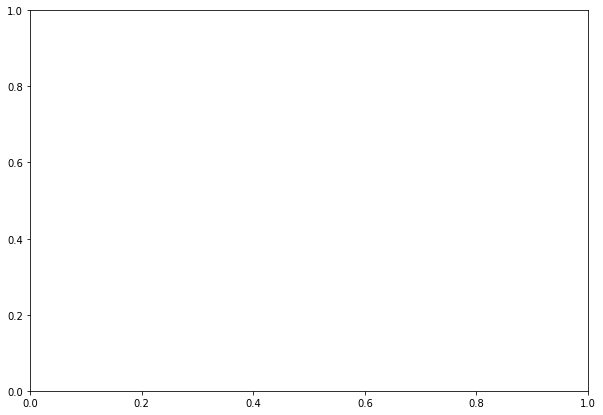

In [ ]:
x = list(range(1,3))
plt.figure(figsize=(10, 7)) 
plt.bar(x,variances[2])
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')